In [ ]:
!pip install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
!git clone https://github.com/biankatpas/Cracks-and-Potholes-in-Road-Images-Dataset

Cloning into 'Cracks-and-Potholes-in-Road-Images-Dataset'...
remote: Enumerating objects: 9261, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 9261 (delta 13), reused 7 (delta 0), pack-reused 9232 (from 1)
Receiving objects: 100% (9261/9261), 220.71 MiB | 16.24 MiB/s, done.
Resolving deltas: 100% (577/577), done.
Updating files: 100% (8952/8952), done.


In [ ]:
import os
import cv2
import numpy as np
from pathlib import Path

# Paths
mask_dir = Path('/content/Cracks-and-Potholes-in-Road-Images-Dataset/Dataset')
output_txt = Path('/content/dataset/labels_all')
output_txt.mkdir(parents=True, exist_ok=True)

# Función para limpiar la máscara
def limpiar_mascara(mask):
    # Remueve ruido con apertura (erosión + dilatación)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    # Suaviza bordes con cierre (dilatación + erosión)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

# Convertir cada máscara a .txt
for carpeta in mask_dir.iterdir():
    if carpeta.is_dir():
        for archivo in carpeta.iterdir():
            if archivo.name.endswith("POTHOLE.png"):
                nombre_base = archivo.name.replace("_POTHOLE.png", "")
                raw_img_path = carpeta / f"{nombre_base}_RAW.jpg"
                if not raw_img_path.exists():
                    continue

                # Leer imagen y máscara
                img = cv2.imread(str(raw_img_path))
                mask = cv2.imread(str(archivo), cv2.IMREAD_GRAYSCALE)
                h, w = mask.shape

                # Limpiar la máscara
                mask = limpiar_mascara(mask)
                _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
                contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                # Guardar anotaciones en formato YOLO
                with open(output_txt / f"{nombre_base}.txt", "w") as f:
                    for cnt in contours:
                        x, y, bbox_w, bbox_h = cv2.boundingRect(cnt)
                        if bbox_w * bbox_h < 20:  # Ignorar cajas muy pequeñas
                            continue
                        x_center = (x + bbox_w / 2) / w
                        y_center = (y + bbox_h / 2) / h
                        w_norm = bbox_w / w
                        h_norm = bbox_h / h
                        f.write(f"0 {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

In [ ]:
import os
import cv2
from pathlib import Path

# Paths
dataset_path = Path("/content/Cracks-and-Potholes-in-Road-Images-Dataset/Dataset")
labels_output = Path("/content/labels_yolo")
labels_output.mkdir(parents=True, exist_ok=True)

# Recorremos cada subcarpeta
for folder in dataset_path.iterdir():
    if folder.is_dir():
        # Extraer los nombres
        raw_img = None
        pothole_mask = None

        for file in folder.iterdir():
            if file.name.endswith("RAW.jpg"):
                raw_img = file
            elif file.name.endswith("POTHOLE.png"):
                pothole_mask = file

        if raw_img and pothole_mask:
            # Leer imagen y máscara
            img = cv2.imread(str(raw_img))
            mask = cv2.imread(str(pothole_mask), cv2.IMREAD_GRAYSCALE)
            height, width = mask.shape

            # Umbralizar la máscara
            _, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # Crear archivo .txt
            label_name = raw_img.stem.replace("_RAW", "") + ".txt"
            label_path = labels_output / label_name

            with open(label_path, "w") as f:
                for cnt in contours:
                    x, y, w, h = cv2.boundingRect(cnt)
                    x_center = (x + w / 2) / width
                    y_center = (y + h / 2) / height
                    w_norm = w / width
                    h_norm = h / height
                    f.write(f"0 {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")


In [ ]:
import shutil

images_output = Path("/content/images_yolo")
images_output.mkdir(parents=True, exist_ok=True)

# Copiar solo las imágenes RAW
for folder in dataset_path.iterdir():
    if folder.is_dir():
        for file in folder.iterdir():
            if file.name.endswith("RAW.jpg"):
                new_name = file.name.replace("_RAW", "")  # Uniformiza el nombre
                shutil.copy(file, images_output / new_name)


In [ ]:
import random

image_files = list(images_output.glob("*.jpg"))
random.shuffle(image_files)
split = int(0.8 * len(image_files))

train_imgs = image_files[:split]
val_imgs = image_files[split:]

# Crear carpetas destino
for phase in ["train", "val"]:
    (Path(f"/content/dataset/images/{phase}")).mkdir(parents=True, exist_ok=True)
    (Path(f"/content/dataset/labels/{phase}")).mkdir(parents=True, exist_ok=True)

# Mover imágenes y etiquetas
for img in train_imgs:
    name = img.stem
    shutil.move(str(img), f"/content/dataset/images/train/{name}.jpg")
    shutil.move(f"/content/labels_yolo/{name}.txt", f"/content/dataset/labels/train/{name}.txt")

for img in val_imgs:
    name = img.stem
    shutil.move(str(img), f"/content/dataset/images/val/{name}.jpg")
    shutil.move(f"/content/labels_yolo/{name}.txt", f"/content/dataset/labels/val/{name}.txt")


In [ ]:
with open("/content/dataset/data.yaml", "w") as f:
    f.write("""
path: /content/dataset
train: images/train
val: images/val
nc: 1
names: ['pothole']
""")


In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8m.pt")
model.train(data="/content/dataset/data.yaml", epochs=10, imgsz=928,augment=True)
metrics = model.val()
print(metrics)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 49.7M/49.7M [00:00<00:00, 146MB/s]


Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=928, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=Tr

100%|██████████| 755k/755k [00:00<00:00, 120MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

  8                  -1  2   3985920  ultralytics.nn.modules.block.C2f             [576, 576, 2, True]           
  9                  -1  1    831168  ultralytics.nn.modules.block.SPPF            [576, 576, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  2   1993728  ultralytics.nn.modules.block.C2f             [960, 384, 2]                 
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  2    517632  ultralytics.nn.modules.block.C2f             [576, 192, 2]                 
 16                  -1  1    332160  ultralytics.nn.modules.conv.Conv             [192,

100%|██████████| 5.35M/5.35M [00:00<00:00, 373MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1965.0±1138.7 MB/s, size: 90.9 KB)


train: Scanning /content/dataset/labels/train... 1788 images, 1336 backgrounds, 0 corrupt: 100%|██████████| 1788/1788 [00:00<00:00, 3539.74it/s]

train: New cache created: /content/dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 540.5±168.3 MB/s, size: 113.6 KB)


val: Scanning /content/dataset/labels/val... 447 images, 335 backgrounds, 0 corrupt: 100%|██████████| 447/447 [00:00<00:00, 2250.25it/s]

val: New cache created: /content/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 928 train, 928 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      12.4G      2.186      5.724      1.642          4        928: 100%|██████████| 112/112 [01:55<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.81it/s]

                   all        447        293          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      12.6G      2.386       3.61      1.977          2        928: 100%|██████████| 112/112 [01:54<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.91it/s]

                   all        447        293      0.198      0.177     0.0945     0.0378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      12.7G      2.553      3.157      2.092          8        928: 100%|██████████| 112/112 [01:54<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  1.88it/s]

                   all        447        293      0.132      0.137     0.0579     0.0213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      12.7G       2.46      3.232      2.048          5        928: 100%|██████████| 112/112 [01:53<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.05it/s]

                   all        447        293      0.296      0.147      0.117     0.0392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      12.7G      2.279      2.867      1.867          6        928: 100%|██████████| 112/112 [01:53<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.07it/s]

                   all        447        293        0.4     0.0888      0.133     0.0575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      12.7G      2.199      2.862      1.828          2        928: 100%|██████████| 112/112 [01:53<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.06it/s]

                   all        447        293      0.308      0.215      0.175     0.0709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      12.7G      2.077      2.458      1.758          0        928: 100%|██████████| 112/112 [01:53<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.06it/s]

                   all        447        293      0.367      0.273       0.23     0.0971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      12.7G      2.094      2.253      1.749          3        928: 100%|██████████| 112/112 [01:53<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:07<00:00,  2.00it/s]

                   all        447        293      0.437      0.307      0.285      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      12.8G      1.949      2.099      1.598          6        928: 100%|██████████| 112/112 [01:53<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.05it/s]

                   all        447        293      0.429      0.324      0.306       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      12.8G      1.918      1.826      1.627          5        928: 100%|██████████| 112/112 [01:53<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:06<00:00,  2.06it/s]

                   all        447        293      0.479      0.379      0.356      0.162



10 epochs completed in 0.351 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:14<00:00,  1.07s/it]


                   all        447        293      0.506      0.372      0.353      0.166
Speed: 0.3ms preprocess, 29.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2228.7±625.0 MB/s, size: 90.9 KB)


val: Scanning /content/dataset/labels/val.cache... 447 images, 335 backgrounds, 0 corrupt: 100%|██████████| 447/447 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:29<00:00,  1.06s/it]


                   all        447        293        0.5      0.372      0.355      0.165
Speed: 1.5ms preprocess, 60.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e70e43d4910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.03


image 1/1 /content/dataset/images/train/1007607_RS_386_386RS289112_28960.jpg: 608x928 (no detections), 133.4ms
Speed: 5.4ms preprocess, 133.4ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 928)
Results saved to runs/detect/train3

image 1/1 /content/dataset/images/train/1007607_RS_386_386RS289112_28960.jpg: 608x928 5 potholes, 67.8ms
Speed: 4.0ms preprocess, 67.8ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 928)


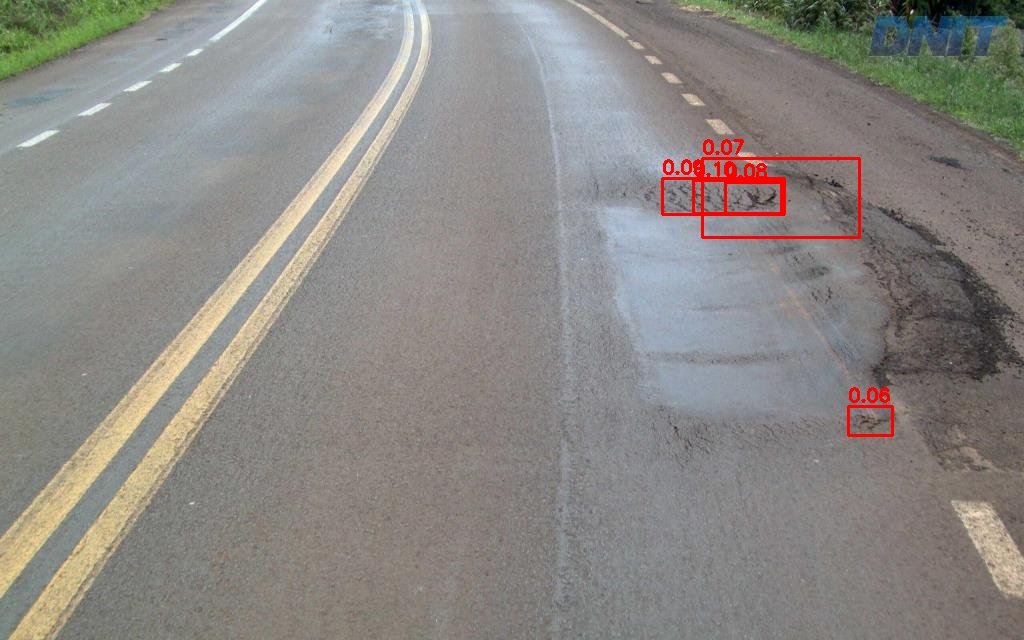

In [ ]:
results = model.predict(
    source='/content/dataset/images/train/1007607_RS_386_386RS289112_28960.jpg',
    save=True,
    conf=0.25
)
import os
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image as IPImage, display

# 📌 Parámetros
img_path = '/content/dataset/images/train/1007607_RS_386_386RS289112_28960.jpg'
output_dir = '/content/resultados_baches'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, os.path.basename(img_path))

# 📌 Cargar imagen original
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 📌 Hacer la predicción
results = model.predict(source=img_path, save=False, conf=0.05)

# 📌 Dibujar cajas sobre la imagen
for box, conf in zip(results[0].boxes.xyxy, results[0].boxes.conf):
    x1, y1, x2, y2 = map(int, box)
    label = f"{conf.item():.2f}"
    cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
    cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# 📌 Guardar la imagen con detecciones
img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite(output_path, img_bgr)

# 📌 Mostrar imagen en Colab
display(IPImage(filename=output_path))

In [ ]:
results = model.predict(source='/content/dataset/images/train/1007607_RS_386_386RS289112_28960.jpg', save=False, conf=0.05)
print(results[0].boxes)  # ver si hay algo


image 1/1 /content/dataset/images/train/1007607_RS_386_386RS289112_28960.jpg: 608x928 5 potholes, 114.1ms
Speed: 4.2ms preprocess, 114.1ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 928)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 0., 0., 0., 0.], device='cuda:0')
conf: tensor([0.0991, 0.0890, 0.0846, 0.0742, 0.0577], device='cuda:0')
data: tensor([[6.9323e+02, 1.8039e+02, 7.8265e+02, 2.1307e+02, 9.9077e-02, 0.0000e+00],
        [6.6245e+02, 1.7862e+02, 7.8432e+02, 2.1422e+02, 8.9007e-02, 0.0000e+00],
        [7.2546e+02, 1.8213e+02, 7.8167e+02, 2.1405e+02, 8.4643e-02, 0.0000e+00],
        [7.0218e+02, 1.5805e+02, 8.5981e+02, 2.3733e+02, 7.4220e-02, 0.0000e+00],
        [8.4807e+02, 4.0626e+02, 8.9200e+02, 4.3565e+02, 5.7678e-02, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (640, 1024)
shape: torch.Size([5, 6])
xywh: tensor([[737.9409, 196.7308,  89.4185,  32.6766],
        [723.3878, 196.4224, 121.8720,  35.5948],